In [61]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import os
from IPython.display import display, clear_output
import scipy.optimize as spo
import iminuit
import uproot
import json

In [63]:
angle = [0]#[0,15,30,45,60,75,85]
file_number_range = [1]#range(1,10)
save_path = "/home/dandrea/abalone_simulation/results/nrbe/"
main_path = "/home/dandrea/abalone_simulation/results/" #Analysis/testing/" #

In [43]:
path = main_path + "tracking/"
file_name = "1_0_track_1.root"

print("reading " + path+file_name)#display("reading " + os.path.join(r,filename))

file = uproot.open(path+file_name)
tree = file["ntuple/ABALONE"]
df = pd.DataFrame(columns=["Event_ID","Parent_ID","Track_ID","Particle","X","Y","Z","Time","KE","DE","Volume"])
df["Event_ID"] = (tree.array("Event_ID")).astype(int)
df["Parent_ID"] = (tree.array("Parent_ID")).astype(int)
df["Track_ID"] = (tree.array("Track_ID")).astype(int)
df["Particle"] = tree.array("Particle")
df["X"] = tree.array("X")
df["Y"] = tree.array("Y")
df["Z"] = tree.array("Z")
df["Time"] = tree.array("Time")
df["KE"] = tree.array("KE")
df["DE"] = tree.array("DE")
df["Volume"] = (tree.array("Volume")).astype(int)

reading /home/dandrea/abalone_simulation/results/tracking/1_0_track_1.root


In [57]:
class track_and_readout:
    
    def __init__(self, pe, angle):
        self.angle = angle
        self.pe = pe
        print("Initializing",self.pe,"pe, at angle",self.angle)
        
        self.area_collection = self.load_readout_data(self)
        self.track_data,self.total_events = self.load_track_data(self)       
        self.e_stat,self.Edep_dist,self.e_ID = self.electron_count(self)
        
    def load_readout_data(self,arg):
        
        collection = []
        
        for num in file_number_range:
            clear_output(wait=True)
            path = main_path + "SiPM/"
            file_name = path + "SiPM_readout_" + str(self.pe) + "_" + str(self.angle) + "_run_" + str(num) +".txt"
            print("reading " + file_name)
            #data = pd.read_json(file_name,lines=True)
            #data_column = np.array(data['voltages']) #.to_numpy()
            #for i in range(len(data_column)):
            #    collection.append(np.trapz(data_column[i]))
            with open(file_name) as f:
                for jsonObj in f:
                    data = json.loads(jsonObj)
                    try: collection.append(data['voltages'])
                    except: pass
                        
        return collection

    def load_track_data(self,arg):

        all_loaded_data = pd.DataFrame(columns=["Event_ID","Parent_ID","Track_ID","Particle","X","Y","Z","Time","KE","DE","Volume"])
        total_len = 0
        
        for num in file_number_range:
            
            clear_output(wait=True)
            
            path = main_path + "tracking/"
            file_name = path + str(self.pe)+"_" + str(self.angle)+"_track_" + str(num) + ".root"
            
            print("reading " + file_name)#display("reading " + os.path.join(r,filename))
            
            file = uproot.open(file_name)
            tree = file["ntuple/ABALONE"]
            df = pd.DataFrame(columns=["Event_ID","Parent_ID","Track_ID","Particle","X","Y","Z","Time","KE","DE","Volume"])
            df["Event_ID"] = (tree.array("Event_ID")).astype(int)+int(total_len)
            df["Parent_ID"] = (tree.array("Parent_ID")).astype(int)
            df["Track_ID"] = (tree.array("Track_ID")).astype(int)
            df["Particle"] = tree.array("Particle")
            df["X"] = tree.array("X")
            df["Y"] = tree.array("Y")
            df["Z"] = tree.array("Z")
            df["Time"] = tree.array("Time")
            df["KE"] = tree.array("KE")
            df["DE"] = tree.array("DE")
            df["Volume"] = (tree.array("Volume")).astype(int)

            df.loc[df["Particle"] == 0 , "Particle"] = "e-"
            df.loc[df["Particle"] == 1 , "Particle"] = "photon"

            frames = [all_loaded_data,df]
            all_loaded_data = pd.concat(frames)
            total_len += len(set(df["Event_ID"].values))

        all_loaded_data["Event_ID"] = pd.to_numeric(all_loaded_data["Event_ID"], downcast='signed')
        return all_loaded_data,total_len
    
   
    def electron_count(self,arg):  #counting non-returning backscattered electron directly, and their energy deposited
    
        non_returning = 0     # electrons getting back-scattered to somewhere else
        non_returning_array = []

        returning_electron = 0     # electrons that end up in the scintillator
        returning_electron_array = []
        
        straight_electron = 0
        straight_electron_array = []
        
        never_electron = 0    # which never goes into the scintillator
        never_array = [] 
        
        non_returning_event=[]
        returning_electron_event=[]
        straight_event = []
        never_event=[]
                
        #display(len(non_returning_array)+len(good_electron_array)+len(never_array))

        for i in range(0,int(max(self.track_data["Event_ID"])+1)):
            event_select = self.track_data['Event_ID'] == i
            electron_select = self.track_data['Parent_ID']==0
            scintillator = self.track_data['Volume'] == 15
            temp = self.track_data[event_select&electron_select]

            for j in range (int(min(temp["Track_ID"])),int(max(temp["Track_ID"])+1)):
                electrons_ID = self.track_data['Track_ID']==j # the data frame for each electron in each event
                each_df = self.track_data[event_select&electron_select&electrons_ID]
                Edep_df = self.track_data[event_select&electron_select&scintillator&electrons_ID]

                energy = Edep_df["DE"].sum()

                if 15 in each_df['Volume'].values and (each_df['Volume'].values)[-1] != 15: #non-returning
                    non_returning += 1
                    non_returning_array.append(energy)
                    non_returning_event.append(i)
                    
                
                flag = 0  # A flag for determining whether it is straight e- or Returning e-
                
                if 15 in each_df['Volume'].values and (each_df['Volume'].values)[-1] == 15: #contains returning and straight electron!
                    vol_array = each_df['Volume'].values
                    for k in range(len(vol_array)-1):
                        if vol_array[k] == 15 and vol_array[k+1]!=15:
                            flag=1
                    
                    if flag == 0:
                        straight_electron += 1
                        straight_electron_array.append(energy)
                        straight_event.append(i)

                    else:
                        returning_electron += 1
                        returning_electron_array.append(energy)
                        returning_electron_event.append(i)
                    
                if not 15 in each_df['Volume'].values:
                    never_electron +=1
                    never_array.append(energy)
                    never_event.append(i)
        
        straight_event = list(set(straight_event))
        non_returning_event=list(set(non_returning_event))
        returning_electron_event=list(set(returning_electron_event))
        never_event=list(set(never_event))
        
        return np.array([straight_electron,returning_electron,non_returning,never_electron]),\
               [straight_electron_array,returning_electron_array,non_returning_array,never_array],\
               [straight_event,returning_electron_event,non_returning_event,never_event]
    
    
    def gaussian(self,x, a,mu,sig):
        return a/(math.sqrt(2.*math.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

    def leastsquare(self,a,mu,sig):  #parameter: mu,sigma and (nu?! is nu = mu?!)
        return sum((self.gaussian(x,a,mu,sig)-y)**2 for x, y in zip(chosen_bin, chosen_yhist))
    
    def fit_peak(self,arg):
        
        yhist,binedges = np.histogram(self.area_collection,bins=100)
        bc = np.array((binedges[1:] + binedges[:-1])/2)
        yhist=np.array(yhist)/yhist.sum()
        
        global chosen_bin
        global chosen_yhist
        
        peak_index = np.argmax(yhist)
        left = 30
        right = len(yhist)-peak_index
        
        chosen_bin = bc[peak_index-left:peak_index+right]
        chosen_yhist= yhist[peak_index-left:peak_index+right]

        m = iminuit.Minuit(self.leastsquare,a=max(yhist),mu=bc[peak_index],sig=500,error_a=10, error_mu=100,error_sig=50,errordef=0.5)
        m.migrad() # run optimiser
        print(m.values)
        m.hesse()
        print(m.errors)  # {'x': 1,'y': 1,'z': 1}
        return m

In [58]:
def show_fit(area_collection):

    yhist,binedges = np.histogram(area_collection,bins=180)
    bc = np.array((binedges[1:] + binedges[:-1])/2)
    #yhist=np.array(yhist)/yhist.sum()

    global chosen_bin
    global chosen_yhist
    
    peak_index = np.argmax(yhist)
    left = 30
    right = len(yhist)-peak_index-10

    chosen_bin = bc[peak_index-left:peak_index+right]
    chosen_yhist= yhist[peak_index-left:peak_index+right]

    plt.plot(bc,yhist)
    plt.hist(binedges[:-1], binedges, weights=yhist,alpha=0.3,color='b')
    plt.axvline(bc[peak_index],color='black',label="Peak location")
    plt.axvline(bc[peak_index-left],color='r')
    plt.axvline(bc[peak_index+right],color='r',label='fitting range')

    m = iminuit.Minuit(leastsquare,a=max(yhist),mu=bc[peak_index],sig=500,error_a=10, error_mu=100,error_sig=50,errordef=0.5)
    m.migrad() # run optimiser
    print(m.values)
    m.hesse()
    print(m.errors)  # {'x': 1,'y': 1,'z': 1}

    xx=np.linspace(3000,max(binedges),100000)
    yy=gaussian(xx, m.values[0],m.values[1],m.values[2])
    plt.title("SiPM area count 1pe -- 0 deg")
    plt.plot(xx,yy,color='green',label="Gaussian Fit")
    plt.legend()
    plt.show()

    gauss_area = np.trapz(yy, x=xx)
    all_area = np.trapz(yhist, x=bc)

    #a1= gauss_area/all_area
    #a2= electron_stats[0]/np.sum(electron_stats)

    #print("Estimated portion of good electrons",a1,"From direct counting:",a2,"diff = ",np.absolute((a1-a2)/a2)*100,"%")

## 1. Estimation of non-returning backscattered electrons
load the files in 1pe at 0 deg

In [59]:
import multiprocessing as mp

In [64]:
pe1_ang0 = track_and_readout(1,0)
#pe1_ang15 = track_and_readout(1,15)
#pe1_ang30 = track_and_readout(1,30)

reading /home/dandrea/abalone_simulation/results/tracking/1_0_track_1.root


In [65]:
#pe1_ang45 = track_and_readout(1,45)
#pe1_ang60 = track_and_readout(1,60)

In [66]:
#pe1_ang75 = track_and_readout(1,75)
#pe1_ang85 = track_and_readout(1,85)

In [67]:
def gaussian(x, a,mu,sig):
        return a/(math.sqrt(2.*math.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

def leastsquare(a,mu,sig):  #parameter: mu,sigma and (nu?! is nu = mu?!)
    return sum((gaussian(x,a,mu,sig)-y)**2 for x, y in zip(chosen_bin, chosen_yhist))

In [80]:
def plot_spectra(obj):
    bin_number = 150
    
    area_straight_list = np.array([obj.area_collection[i] for i in obj.e_ID[0]])
    area_returning_list = [obj.area_collection[i] for i in obj.e_ID[1]] 
    area_non_list = [obj.area_collection[i] for i in obj.e_ID[2]]

    yhist,binedges = np.histogram(area_straight_list,bins=bin_number)
    bc = np.array((binedges[1:] + binedges[:-1])/2)

    peak_index = np.argmax(yhist)
    left = 30
    right = len(yhist)-peak_index - 1

    global chosen_bin
    global chosen_yhist

    chosen_bin = bc[peak_index-left:peak_index+right]
    chosen_yhist= yhist[peak_index-left:peak_index+right]
    
    #m = iminuit.Minuit(leastsquare,a=max(yhist),mu=bc[peak_index],sig=500,error_a=100, error_mu=100,error_sig=500,errordef=0.5)
    m = iminuit.Minuit(leastsquare,a=max(yhist),mu=bc[peak_index],sig=500)
    m.migrad()
    m.hesse()
    print(m.values)
    #print(m.errors)

    x= np.linspace(5000,12000,60000)
    y = gaussian(x,m.values[0],m.values[1],m.values[2])

    plt.scatter(bc,yhist,label = "Straight electrons distribusion")
    plt.scatter(chosen_bin,chosen_yhist,color='r',label="Fitting Data Points")
    plt.plot(x,y)
    plt.axvline(bc[peak_index-left],color='red',linestyle=":")
    plt.axvline(bc[peak_index+right],color='red',linestyle=":",label = "Fitting Range")
    plt.ylim(0)
    plt.legend(prop={'size': 8})
    plt.show()
    
    stat = obj.e_stat
    print(" ** Summary of the electrons ** ")
    print("Portion of electron getting backscattered in scintillator",(stat[1]+stat[2])/np.sum(stat))
    print("Portion of Returning back-scattered electrons",(stat[1])/np.sum(stat))
    print("Portion of Non-returning back-scattered electrons",(stat[2])/np.sum(stat))
    print("Portion of undetected electrons",(stat[3])/np.sum(stat))

    ########################
    ########################

    fig, axs = plt.subplots(2,2,figsize=(13,8))
    axs[0,0].hist(area_straight_list,bins=bin_number,label = "Straight e-",histtype='step',color='g') #,normed=True
    axs[0,0].hist(area_returning_list,bins=bin_number,label = "Returning e-",histtype='step',color='b') #,normed=True
    axs[0,0].hist(area_non_list,bins=bin_number,label = "Non-retrurning",histtype='step',color='r') #,log=True   ,normed=True
    axs[0,0].plot(x,y,label="Gaussian Fit",color = 'black')
    axs[0,0].set_title("SiPM area count",fontsize=11)
    axs[0,0].legend(prop={'size': 8})
    axs[0,0].set(xlabel="Area")
    axs[0,0].relim()
    axs[0,0].autoscale_view()

    axs[1,0].hist(pe1_ang0.Edep_dist[0],bins=bin_number,histtype='step',label = "Straight e-",color='g') #,log=True
    axs[1,0].hist(pe1_ang0.Edep_dist[1],bins=bin_number,histtype='step',label = "Returning e-",color='b') #,log=True
    axs[1,0].hist(pe1_ang0.Edep_dist[2],bins=bin_number,histtype='step',label = "Non-retrurning",color='r')
    axs[1,0].set_title("Energy depposited",fontsize=11)
    axs[1,0].set(xlabel="Energy (keV)")
    axs[1,0].legend(prop={'size': 8})

    axs[0,1].hist(area_straight_list,bins=bin_number,label = "Straight e-",histtype='step',color='g',log=True) #,normed=True
    axs[0,1].hist(area_returning_list,bins=bin_number,label = "Returning e-",histtype='step',color='b',log=True) #,normed=True
    axs[0,1].hist(area_non_list,bins=bin_number,label = "Non-retrurning",histtype='step',color='r',log=True) #,log=True   ,normed=True
    axs[0,1].set_title("SiPM area count (log-scale)",fontsize=11)
    axs[0,1].legend(prop={'size': 8})
    axs[0,1].set(xlabel='Area')

    axs[1,1].hist(pe1_ang0.Edep_dist[0],bins=bin_number,histtype='step',color='g',label = "Straight e-",log=True) #,log=True
    axs[1,1].hist(pe1_ang0.Edep_dist[1],bins=bin_number,histtype='step',color='b',label = "Returning e-",log=True) #,log=True
    axs[1,1].hist(pe1_ang0.Edep_dist[2],bins=bin_number,histtype='step',color='r',label = "Non-retrurning",log=True) #,log=True
    axs[1,1].legend(prop={'size': 8})
    axs[1,1].set_title("Energy depposited (log-scale)",fontsize=11)
    axs[1,1].set(xlabel="Energy (keV)")

    fig.suptitle(str(obj.pe)+ " pe event Spectra at angle "+str(obj.angle)+" deg",fontsize=12)
    plt.subplots_adjust(hspace = 0.25)
    path = save_path+"plots/"
    if not os.path.exists(path):
        os.makedirs(path)
        
    plt.savefig(path+"Spectra_"+str(obj.pe)+"_pe_angle_"+str(obj.angle))
        
    plt.show()


/usr/share/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)


<ValueView a=2020.6878389365024 mu=95.83991165265031 sig=25.447383476700328>


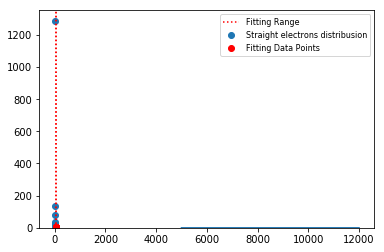

 ** Summary of the electrons ** 
Portion of electron getting backscattered in scintillator 0.8
Portion of Returning back-scattered electrons 0.2
Portion of Non-returning back-scattered electrons 0.6
Portion of undetected electrons 0.0


ValueError: color kwarg must have one color per data set. 2000 data sets and 1 colors were provided

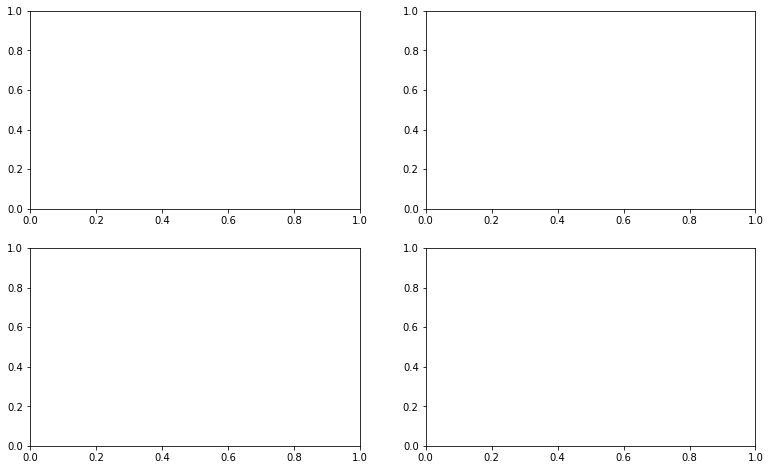

In [81]:
plot_spectra(pe1_ang0)
#plot_spectra(pe1_ang15)
#plot_spectra(pe1_ang30)
#plot_spectra(pe1_ang45)
#plot_spectra(pe1_ang60)
#plot_spectra(pe1_ang75)
#plot_spectra(pe1_ang85)

In [57]:
def e_stat_bootstrap(obj):
    e_stat = obj.e_stat
    s = np.ones(e_stat[0])
    r = np.ones(e_stat[1])*2
    nr = np.ones(e_stat[2])*3
    ne = np.ones(e_stat[3])*4
    sample = np.concatenate([s, r,nr,ne], axis=None)
    
    bootstrap_trials = 10000
    bootstrap_nr_portion = []
    bootstrap_s_portion = []
    bootstrap_r_portion = []
    bootstrap_ne_portion= []
    
    for x in range(0, bootstrap_trials):
        bootstrap_data = np.random.choice(sample, 8000, replace=True)
        # count the number of non-returning back-scattered e-
        bootstrap_nr_stat = np.sum(bootstrap_data == 3)/len(bootstrap_data)
        bootstrap_s_stat = np.sum(bootstrap_data == 1)/len(bootstrap_data)
        bootstrap_r_stat = np.sum(bootstrap_data == 2)/len(bootstrap_data)
        bootstrap_ne_stat = np.sum(bootstrap_data == 4)/len(bootstrap_data)

        bootstrap_nr_portion += [np.average(bootstrap_nr_stat)]
        bootstrap_s_portion += [np.average(bootstrap_s_stat)]
        bootstrap_r_portion += [np.average(bootstrap_r_stat)]
        bootstrap_ne_portion += [np.average(bootstrap_ne_stat)]
        
    bootstrap_nr_sorted = np.sort(bootstrap_nr_portion)
    bootstrap_ne_sorted = np.sort(bootstrap_ne_portion)
    bootstrap_s_sorted = np.sort(bootstrap_s_portion)
    bootstrap_r_sorted = np.sort(bootstrap_r_portion)
    
    plt.hist(bootstrap_nr_portion,bins=25)
    plt.axvline(bootstrap_nr_sorted[int(bootstrap_trials*0.05)],color='r')
    plt.axvline(bootstrap_nr_sorted[int(bootstrap_trials*0.95)],color='r')
    plt.title("Bootstrapping of the portion of NRBE at " + str(obj.pe) + " pe angle "+str(obj.angle)+" deg",fontsize=11)
    path = save_path+"plots/NRBE/"
    if not os.path.exists(path):
        os.makedirs(path)
        
    plt.savefig(path+str(obj.pe)+"_pe_angle_"+str(obj.angle))
    plt.show()
    
    nr_stat = [np.median(bootstrap_nr_portion),bootstrap_nr_sorted[int(bootstrap_trials*0.05)],\
               bootstrap_nr_sorted[int(bootstrap_trials*0.95)],np.std(bootstrap_nr_portion)]
    ne_stat = [np.median(bootstrap_ne_portion),bootstrap_ne_sorted[int(bootstrap_trials*0.05)],\
               bootstrap_ne_sorted[int(bootstrap_trials*0.95)],np.std(bootstrap_ne_portion)]
    s_stat = [np.median(bootstrap_s_portion),bootstrap_s_sorted[int(bootstrap_trials*0.05)],\
               bootstrap_s_sorted[int(bootstrap_trials*0.95)],np.std(bootstrap_s_portion)]
    r_stat = [np.median(bootstrap_r_portion),bootstrap_r_sorted[int(bootstrap_trials*0.05)],\
               bootstrap_r_sorted[int(bootstrap_trials*0.95)],np.std(bootstrap_r_portion)]
    return [s_stat,r_stat,nr_stat,ne_stat]

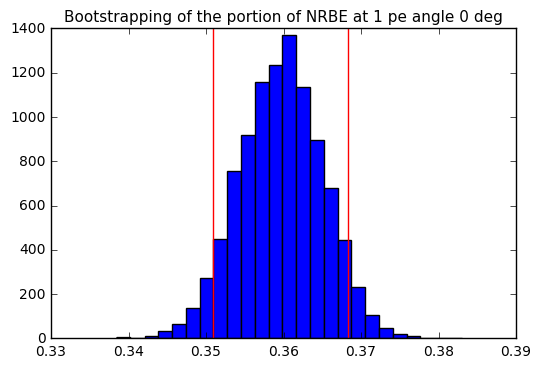

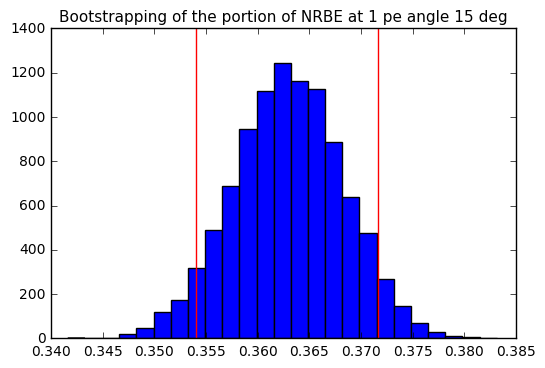

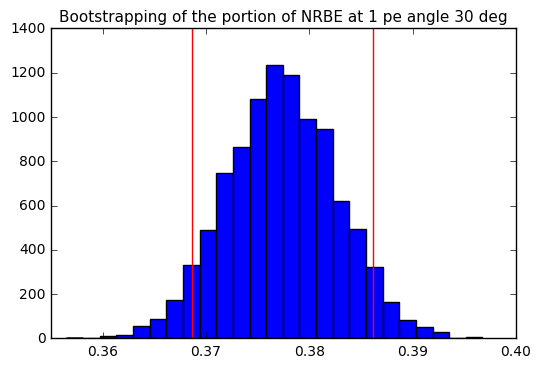

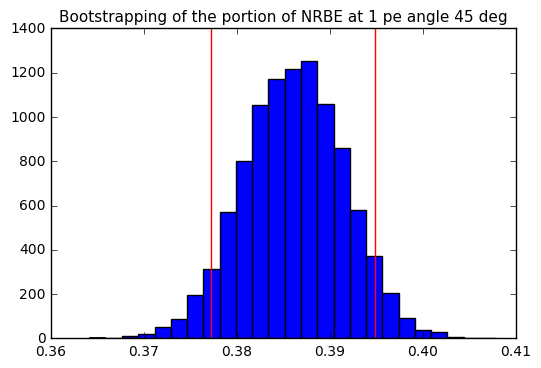

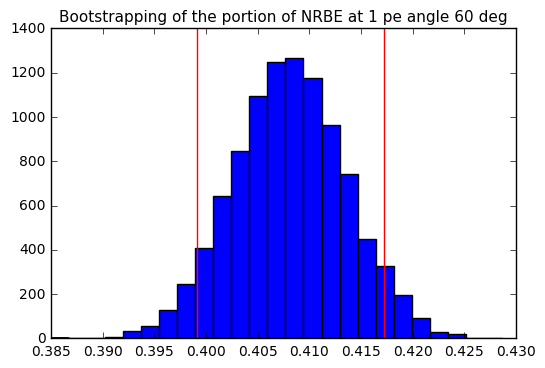

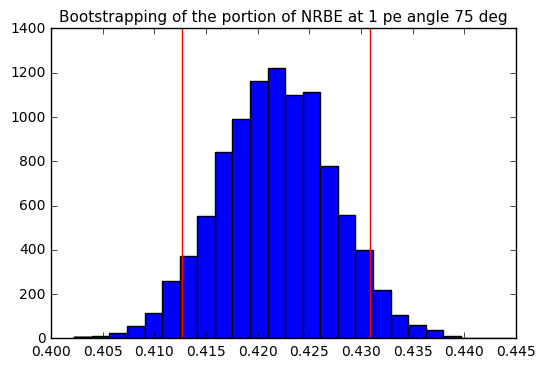

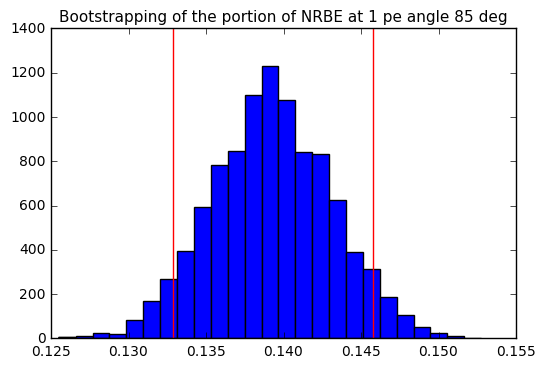

In [58]:
stat_1_0=e_stat_bootstrap(pe1_ang0)
stat_1_15=e_stat_bootstrap(pe1_ang15)
stat_1_30=e_stat_bootstrap(pe1_ang30)
stat_1_45=e_stat_bootstrap(pe1_ang45)
stat_1_60=e_stat_bootstrap(pe1_ang60)
stat_1_75=e_stat_bootstrap(pe1_ang75)
stat_1_85=e_stat_bootstrap(pe1_ang85)

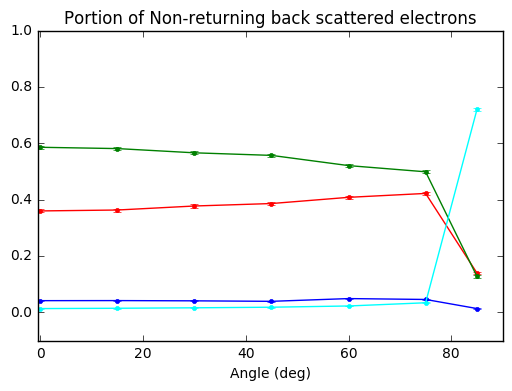

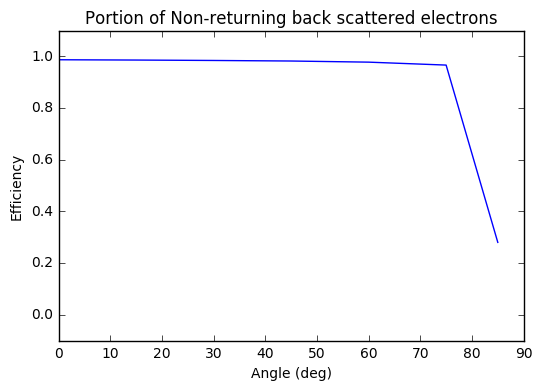

In [76]:
stat_set = [stat_1_0,stat_1_15,stat_1_30,stat_1_45,stat_1_60,stat_1_75,stat_1_85]

SE = [i[0][0] for i in stat_set]
SE_var = [i[0][3] for i in stat_set]
RE = [i[1][0] for i in stat_set]
RE_var = [i[1][3] for i in stat_set]
NRBE = [i[2][0] for i in stat_set]
NRBE_var = [i[2][3] for i in stat_set]
NE = [i[3][0] for i in stat_set]
NE_var = [i[3][3] for i in stat_set]

angle = [0,15,30,45,60,75,85]
plt.errorbar(angle,NRBE,yerr=NRBE_var,fmt='.',label="NRBE",color="Red")
plt.errorbar(angle,SE,yerr=SE_var,fmt='.',label="Straight e-",color="Green")
plt.errorbar(angle,RE,yerr=RE_var,fmt='.',label="Returning",color="Blue")
plt.errorbar(angle,NE,yerr=NE_var,fmt='.',label="Never",color="cyan")

plt.plot(angle,NRBE,color="Red")
plt.plot(angle,SE,color="Green")
plt.plot(angle,RE,color="Blue")
plt.plot(angle,NE,color="cyan")


plt.ylim(-0.1,1)
plt.xlim(-0.5,90)

plt.title("Portion of Non-returning back scattered electrons")
plt.xlabel('Angle (deg)')
path = save_path+"plots/NRBE/"
plt.savefig(path+"Portion",transparent=False)
plt.show()


eff = np.array([stat_1_0[3][0],stat_1_15[3][0],stat_1_30[3][0],stat_1_45[3][0],stat_1_60[3][0],stat_1_75[3][0],stat_1_85[3][0]])
plt.plot(np.array([0,15,30,45,60,75,85]),1-eff)
plt.title("Portion of Non-returning back scattered electrons")
plt.xlabel('Angle (deg)')
plt.ylabel('Efficiency')
plt.ylim(-0.1,1.1)
path = save_path+"plots/NRBE/"
plt.savefig(path+"Detector_Efficiency",transparent=False)
plt.show()


### Comparing with the tracking data

In [44]:
stat_1_85

[0.139125, 0.13275, 0.1455, 0.003816448971045432]

### Reponses time of ABALONE -- only consider the total time for event

The peak at time ~ 1.9 ns should be the time for most photons being generated in the scinillator

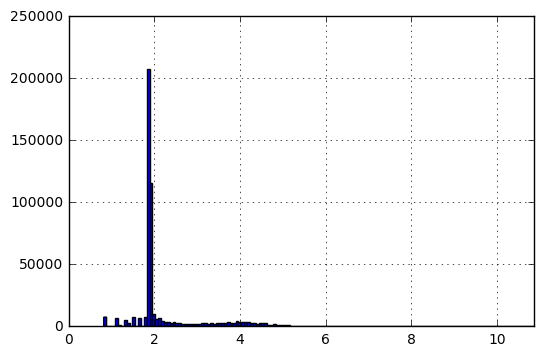

In [251]:
values = df["Time"].iloc[df["Time"].nonzero()] 
values.hist(bins=150)
plt.xlim(0,max(values))
plt.show()

## ----- END ----- 

codes below are only reserved.

In [ ]:
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter

def myplot(x, y, s, bins=1000):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent


fig, axs = plt.subplots(2, 2)

# Generate some test data
x = np.random.randn(1000)
y = np.random.randn(1000)

sigmas = [0, 16, 32, 64]

for ax, s in zip(axs.flatten(), sigmas):
    if s == 0:
        ax.plot(x, y, 'k.', markersize=5)
        ax.set_title("Scatter plot")
    else:
        img, extent = myplot(x, y, s)
        ax.imshow(img, extent=extent, origin='lower', cmap=cm.jet)
        ax.set_title("Smoothing with  $\sigma$ = %d" % s)

plt.show()

### Estimation of Non-returning backscattered electrons

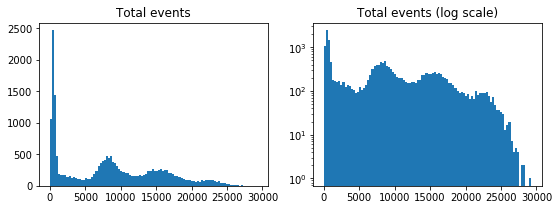

11869 23096 11500 6538


In [30]:
total_area_collection = area_collection_0pe[0:5000] + area_collection_1pe[0:5000]+area_collection_2pe[0:5000]+area_collection_3pe[0:5000] #+area_collection_4pe
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(9,3))
ax[0].hist(total_area_collection,bins=100)
ax[1].hist(total_area_collection,bins=100,log=True)
ax[0].title.set_text("Total events")
ax[1].title.set_text("Total events (log scale)")
plt.show()
fig.savefig("Total_events.png",transparent=False)
# there is no need to have too many data on the 0 pe event


print(len(area_collection_0pe),len(area_collection_1pe),len(area_collection_2pe),len(area_collection_3pe))

fig, ax = plt.subplots(figsize=(10,10))

ax.plot(sample_0,color = 'green',label="0 pe")
ax.plot(sample_1,color = 'blue',label="1 pe")
ax.plot(sample_2,color = 'red',label="2 pe")

ax.title.set_text("SiPM readout for different pe events")
plt.legend()

fig.savefig("SiPM_readout.png",transparent=False)
plt.show()

In [9]:
print(len(area_collection_0pe),len(area_collection_1pe),len(area_collection_2pe))

8084 10745 11500


In [33]:
a = [1,2,3,4,5,6,7,8]
print(a[1,2,3])

TypeError: list indices must be integers, not tuple